# Segmenting and Clustering Neighborhoods in Toronto

### Scraping the Wikipedia page

Opening the wikipedia page and reading it with BeautifulSoup. (I use %reset to be sure that no variable associated to previous attempts is stored) 

In [1]:
#%reset
import requests
from bs4 import BeautifulSoup
wikipageurl='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_wikipedia_page = requests.get(wikipageurl)
page = raw_wikipedia_page.content
bspage = BeautifulSoup(page, "lxml")


The interesting tab can be found in "table". We split it using the marker 'tr', which defines each new line

In [2]:
tableall=bspage.table.findAll('tr')

We create an empty dataframe in Pandas.
Then, we read all the rows in the tabular. If the row has three columns, we use it to populate the dataframe

In [3]:
import pandas as pd
columnheaders=['PostalCode','Neighborhood','Borough']
df=pd.DataFrame(columns=columnheaders)

In [4]:


for i in tableall:
    row=i.findAll('td')
    if len(row)==3:
        df=pd.concat([df,pd.DataFrame({'PostalCode': [row[0].text],'Borough': [row[1].text],'Neighborhood': [row[2].text[0:-1]]})],sort=False)

Here, we clean the dataframe, removing all the cells where "assigned" (as in "not assigned) is visble.
Then, we define the indexes of the rows from 0 to the number of rows.
We also remove duplicate names of Neighborhoods

In [5]:
#df=df.set_index('PostalCode')
df=df[~df['Neighborhood'].str.contains('assigned')]

df=df.sort_values(by=['Neighborhood'])
df.drop_duplicates(subset=['Neighborhood'], keep='first',inplace=True)
df.index = range(df.shape[0])
print(df)

    PostalCode                                      Neighborhood  \
0          M5H                                          Adelaide   
1          M1S                                         Agincourt   
2          M1V                                   Agincourt North   
3          M9V                                    Albion Gardens   
4          M8W                                         Alderwood   
5          M3H                                    Bathurst Manor   
6          M5V                                     Bathurst Quay   
7          M2K                                   Bayview Village   
8          M9V                                  Beaumond Heights   
9          M5M                                      Bedford Park   
10         M5E                                       Berczy Park   
11         M1N                                       Birch Cliff   
12         M9C                                 Bloordale Gardens   
13         M6K                                  

In [6]:
df.head()

,PostalCode,Neighborhood,Borough
0,M5H,Adelaide,Downtown Toronto
1,M1S,Agincourt,Scarborough
2,M1V,Agincourt North,Scarborough
3,M9V,Albion Gardens,Etobicoke
4,M8W,Alderwood,Etobicoke


In [7]:
df.shape

(209, 3)

### Part 2: finding the locations of each Neighbourhood

Defining a progressbar (code from there: https://gist.github.com/vladignatyev/06860ec2040cb497f0f3); makes the progress more beautiful

In [8]:
import sys

def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * (count+1) / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status+'                        '))
    sys.stdout.flush() # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#comment50529068_27871113)


In [9]:
df['Latitude']=0
df['Longitude']=0
print(df.head())


  PostalCode     Neighborhood           Borough  Latitude  Longitude
0        M5H         Adelaide  Downtown Toronto         0          0
1        M1S        Agincourt       Scarborough         0          0
2        M1V  Agincourt North       Scarborough         0          0
3        M9V   Albion Gardens         Etobicoke         0          0
4        M8W        Alderwood         Etobicoke         0          0


In [10]:
import geocoder
import datetime
import time


##### Finding the lat/lon coordinates
Note that here, I use the arcgis geocoder instead of google one, because it has no call limits.

In [11]:
for index, row in df.iterrows():
    location =  str(row["PostalCode"]) + ", Toronto, ON, Canada"
    location =  str(row["Neighborhood"]) + ', ' + str(row["Borough"]) + ", Toronto, ON, Canada"
    progress(index,len(df.index),str(row["Neighborhood"]) + ', ' + str(row["Borough"]))


    # Code from coursera
    lat_lng_coords = None
    attempt=0
    while(lat_lng_coords is None):
        #time.sleep(1)   
        attempt=attempt+1
        ggg = geocoder.arcgis(location)
        lat_lng_coords = ggg.latlng
    row['Latitude'] = lat_lng_coords[0]
    row['Longitude'] = lat_lng_coords[1]
    df.iloc[index,:]=row
   

In [12]:
print(df.head())

  PostalCode     Neighborhood           Borough   Latitude  Longitude
0        M5H         Adelaide  Downtown Toronto  43.653320 -79.364010
1        M1S        Agincourt       Scarborough  43.785980 -79.280200
2        M1V  Agincourt North       Scarborough  43.809300 -79.267070
3        M9V   Albion Gardens         Etobicoke  43.695111 -79.286046
4        M8W        Alderwood         Etobicoke  43.604960 -79.541160


## Neighbourhood analysis

In [13]:
CLIENT_ID = 'UIRSCSXIXPDESJTRUONY3YOBZXWBXY2DCSZIFV142FLHSW22' # your Foursquare ID
CLIENT_SECRET = 'IAESIJQMBQTURNZNHXVFFJD3JYIWSW2JV1B5A42RF4IJEO3Z' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL

Same as on the exercise. I just added a progressbar.

In [14]:


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng, idx in zip(names, latitudes, longitudes, range(len(latitudes))):
        progress(idx,len(latitudes),'Getting nearby venues... ')
        while True: #The while True/except continue/ else break is made to rerun the lines in case we get an error  https://stackoverflow.com/questions/4606919/in-python-try-until-no-error
            try:    
            # create the API request URL
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT)

                # make the GET request
                results = requests.get(url).json()["response"]['groups'][0]['items']

                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])
            except:
                continue
            else:
                break
                
                
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [15]:
manhattan_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])



In [16]:
print(manhattan_venues.head())


  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Adelaide               43.65332               -79.36401   
1     Adelaide               43.65332               -79.36401   
2     Adelaide               43.65332               -79.36401   
3     Adelaide               43.65332               -79.36401   
4     Adelaide               43.65332               -79.36401   

                       Venue  Venue Latitude  Venue Longitude  \
0             Rooster Coffee       43.651900       -79.365609   
1           Roselle Desserts       43.653447       -79.362017   
2              Tandem Coffee       43.653559       -79.361809   
3  Mangia and Bevi Resto-Bar       43.652250       -79.366355   
4           Cocina Economica       43.654959       -79.365657   

       Venue Category  
0         Coffee Shop  
1              Bakery  
2         Coffee Shop  
3  Italian Restaurant  
4  Mexican Restaurant  


In [17]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]


In [18]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
print(manhattan_grouped.shape)
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)


(206, 312)


## Clustering
##### Import the libraries

In [19]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline





##### Use the Elbow method to determine the number of clusters

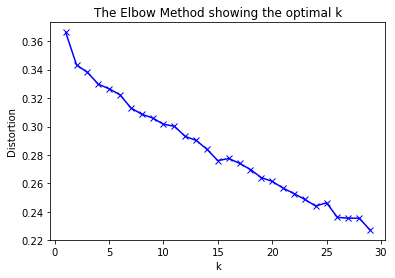

In [20]:
# k means determine k
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(manhattan_grouped_clustering)
    kmeanModel.fit(manhattan_grouped_clustering)
    distortions.append(sum(np.min(cdist(manhattan_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / manhattan_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##### We decide to use k=3

In [21]:
# import k-means from clustering stage
kclusters = 3


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)


#Neighbourg clusters is a the list of clusters for each Neighborhood
#I added 1 so that the labels go from 1 to 3 (0 will be dedicated to neighboorhoods that have no shops and are thus not classified)
neighbo_clusters=pd.DataFrame({'Cluster': kmeans.labels_[:]+1},index=manhattan_grouped["Neighborhood"])



For each cluster, I print the top 10 venues to check which type of place it is

In [22]:
num_top_venues = 10

clus=None
for numcluster in range(kclusters):
    print('=== Cluster ' + str(numcluster+1) + ' ===')
    clus=pd.Series(data=kmeans.cluster_centers_[numcluster],index=manhattan_onehot.drop('Neighborhood', 1).columns)
    print(clus.sort_values(ascending=False).head(num_top_venues))
    print(' ')

=== Cluster 1 ===
Park                 0.314464
Convenience Store    0.047946
Bus Line             0.030702
Hotel                0.028509
Moving Target        0.026316
Grocery Store        0.024700
Bus Station          0.021930
Coffee Shop          0.021630
Massage Studio       0.021303
Bakery               0.018233
dtype: float64
 
=== Cluster 2 ===
Park                     1.000000e+00
Vietnamese Restaurant    1.734723e-18
Restaurant               1.734723e-18
Bus Stop                 8.673617e-19
Pet Store                8.673617e-19
Tea Room                 8.673617e-19
Diner                    8.673617e-19
Pool                     4.336809e-19
Music Store              2.168404e-19
Cocktail Bar             2.168404e-19
dtype: float64
 
=== Cluster 3 ===
Coffee Shop           0.078372
Pizza Place           0.048777
Café                  0.034004
Pharmacy              0.027102
Sandwich Place        0.021333
Italian Restaurant    0.018624
Bakery                0.017748
Grocery Store  

Cluster 2 has only parks, Cluster 3 has a lot of restaurants, Cluster 1 is more balanced

In [29]:
neighbo_clusters.head()

,Cluster
Neighborhood,
Adelaide,3
Agincourt,3
Agincourt North,3
Albion Gardens,3
Alderwood,3


In [30]:
dfc=pd.concat([df.set_index('Neighborhood'), neighbo_clusters], axis=1, sort=False, join='outer')
dfc=dfc.fillna(0) # Neighborhoods not clustered correspond to neighborhoods without any shop, and thus are put in the same cluster 0

In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dfc)

                                                 PostalCode           Borough  \
Adelaide                                                M5H  Downtown Toronto   
Agincourt                                               M1S       Scarborough   
Agincourt North                                         M1V       Scarborough   
Albion Gardens                                          M9V         Etobicoke   
Alderwood                                               M8W         Etobicoke   
Bathurst Manor                                          M3H        North York   
Bathurst Quay                                           M5V  Downtown Toronto   
Bayview Village                                         M2K        North York   
Beaumond Heights                                        M9V         Etobicoke   
Bedford Park                                            M5M        North York   
Berczy Park                                             M5E  Downtown Toronto   
Birch Cliff                 

## Now making the map

Open a map, using the central coordinates of Toronto

In [32]:
import folium

lat_lng_coords=None
while(lat_lng_coords is None):
        #time.sleep(1)   
        attempt=attempt+1
        ggg = geocoder.arcgis("Toronto, Canada")
        lat_lng_coords = ggg.latlng
        
        
mymap=folium.Map(location=lat_lng_coords, zoom_start=11)

Plot the different neighborhoods using different colors

In [33]:
listofcolors=['green','beige','blue','red']
for index,row in dfc.iterrows():    
    folium.Marker([row['Latitude'],row['Longitude']], icon=folium.Icon(color=str(listofcolors[int(row['Cluster'])]))).add_to(mymap)



In [34]:
display(mymap)

In [37]:
mymap.save('./mapToronto.html')

### Note: the map does not display in Github, so I attach it in a html file.